Here we show how to get a smooth power spectrum, without the BAO oscillations.

# Importing libraries

In [31]:
import sys
sys.path.append('/Users/s2223060/Desktop/primordial_features/')
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mcfit import xi2P, P2xi
from scipy import integrate

# Running camb

In [32]:
import camb

Loading the params.ini file for a specific cosmology:

In [5]:
cosmo_dir = '/Users/s2223060/Desktop/primordial_features/cosmologies/'
cosmo_file = 'desi_QSO_params.ini'
pars = camb.read_ini(cosmo_dir+cosmo_file, no_validate=False)

In [6]:
pars.Transfer

class: <TransferParams>
 high_precision = True
 accurate_massive_neutrinos = False
 kmax = 673.6
 k_per_logint = 5
 PK_num_redshifts = 1
 PK_redshifts = [1.491]
 

Computing the linear matter power spectrum:

In [7]:
results = camb.get_results(pars)

In [8]:
kh, Z, plin_camb = results.get_matter_power_spectrum(minkh=1e-7, maxkh=1000, npoints = 10000)
plin_camb = plin_camb[0]

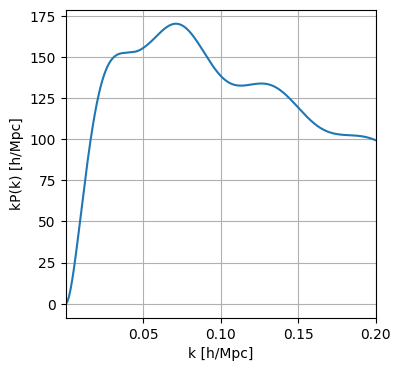

In [9]:
plt.figure(figsize = (4,4))
plt.plot(kh, kh*plin_camb)
plt.xlim((1e-4,0.2))
plt.xlabel("k [h/Mpc]")
plt.ylabel("kP(k) [h/Mpc]")
plt.grid()

In [10]:
to_save = np.vstack((kh, plin_camb))

In [11]:
np.savetxt('plin_DESI_z_1.2.txt', to_save)

In [12]:
kh, plin_camb = np.loadtxt('plin_DESI_z_1.2.txt')

# Eisenstein & Hu smooth power spectrum

We start using the Eistenstein & Hu fitting formula w/o the wiggles (https://arxiv.org/abs/astro-ph/9709112)

In [13]:
# Define constants
T_CMB = pars.TCMB  # CMB temperature in Kelvin
e = np.exp(1)

# Define cosmological parameters
ombh2          = pars.ombh2
omch2          = pars.omch2
h = pars.h  # Dimensionless Hubble parameter

Omega_b = ombh2/h**2
Omega_c = omch2/h**2

Omega_m = Omega_b +  Omega_c # Matter density parameter
ns = pars.InitPower.ns

In [14]:
def no_wiggle_eisenstein_hu(k, Omega0_m, Omega0_b, h, Tcmb0):
    """
    Compute the Eisenstein & Hu (1998) transfer function without BAO wiggles.

    Parameters
    ----------
    k : float or array_like
        The wavenumbers in units of h Mpc^-1.
    Omega0_m : float
        The matter density parameter.
    Omega0_b : float
        The baryon density parameter.
    h : float
        The dimensionless Hubble parameter.
    Tcmb0 : float
        The CMB temperature in Kelvin.
    redshift : float
        The redshift of the power spectrum.

    Returns
    -------
    Tk : float or array_like
        The transfer function evaluated at k, normalized to unity on large scales.
    """
    Obh2 = Omega0_b * h ** 2
    Omh2 = Omega0_m * h ** 2
    f_baryon = Omega0_b / Omega0_m
    theta_cmb = Tcmb0 / 2.7

    # Wavenumber of equality
    k_eq = 0.0746 * Omh2 * theta_cmb ** (-2)  # units of 1/Mpc

    # Sound horizon
    sound_horizon = h * 44.5 * np.log(9.83 / Omh2) / np.sqrt(1 + 10 * Obh2 ** 0.75)  # in Mpc/h

    # Alpha gamma
    alpha_gamma = 1 - 0.328 * np.log(431 * Omh2) * f_baryon + 0.38 * np.log(22.3 * Omh2) * f_baryon ** 2

    # Handle scalar and array-like k values
    if np.isscalar(k) and k == 0.:
        return 1.0

    k = np.asarray(k)
    valid = k > 0.

    k = k[valid] * h  # in 1/Mpc now
    ks = k * sound_horizon / h
    q = k / (13.41 * k_eq)

    gamma_eff = Omh2 * (alpha_gamma + (1 - alpha_gamma) / (1 + (0.43 * ks) ** 4))
    q_eff = q * Omh2 / gamma_eff
    L0 = np.log(2 * np.e + 1.8 * q_eff)
    C0 = 14.2 + 731.0 / (1 + 62.5 * q_eff)

    T = np.ones(valid.shape)
    T[valid] = L0 / (L0 + C0 * q_eff ** 2)
    return T

def ps_nw_eisenstein_hu(k, Omega0_m, Omega0_b, h, Tcmb0, ns):
    T = no_wiggle_eisenstein_hu(k, Omega0_m, Omega0_b, h, Tcmb0)
    return k**ns*T**2

def sigma8_integrand(k, Pk):
    R = 8.0  # Radius in h^-1 Mpc
    W = (3 * (np.sin(k * R) - k * R * np.cos(k * R)) / (k * R)**3)**2
    return k**2 * Pk * W

def compute_sigma8(k, Pk):
    integrand = sigma8_integrand(k, Pk)
    result = integrate.simps(integrand, k)
    return np.sqrt(result / (2 * np.pi**2))

Get the smooth power spectrum from the Eisenstein & Hu formula and normalise it to match the input 

In [15]:
ps_nw = ps_nw_eisenstein_hu(kh, Omega_m, Omega_b, h, T_CMB, ns)

#Get the normalisation by imposing the right sigma8
norm = (compute_sigma8(kh, plin_camb)/compute_sigma8(kh, ps_nw))**2
ps_nw *= norm

Text(0, 0.5, '$\\mathcal{O}_{\\rm lin}$')

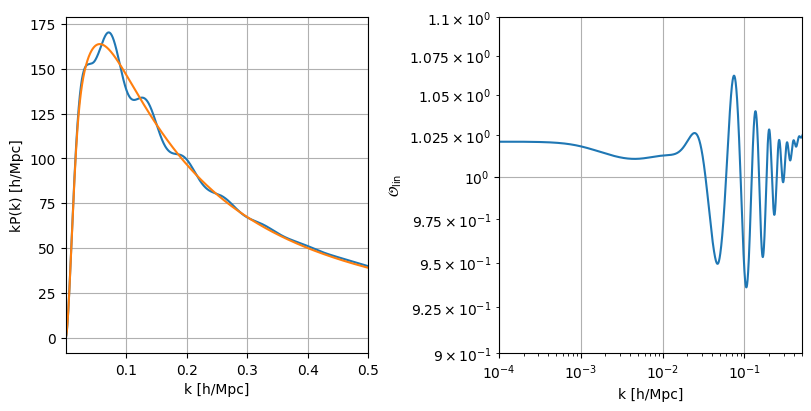

In [16]:
fig, ax = plt.subplots(1,2, figsize = (8,4), constrained_layout = True)
ax[0].plot(kh,kh*plin_camb)
ax[0].plot(kh,kh*ps_nw)
ax[0].set_xlim((1e-4,0.5))
ax[0].grid()
ax[0].set_xlabel("k [h/Mpc]")
ax[0].set_ylabel("kP(k) [h/Mpc]")

ax[1].loglog(kh,plin_camb/ps_nw)
ax[1].set_xlim((1e-4,0.5))
ax[1].set_ylim((0.9,1.1))
ax[1].grid()
ax[1].set_xlabel("k [h/Mpc]")
ax[1].set_ylabel(r'$\mathcal{O}_{\rm lin}$')

To improve the smooth power spectrum precision, we will take the Hankel transform of the linear matter power spectrum and "erase" the BAO bump in the correlation function:

Assume that the BAO bump is concentrated in an interval $s_{\rm BAO} = [s_0, s_1]$. Also, we denote $\xi_{lin}$ and $\xi_{EH}$ as the correlation function from a Boltmann solver and the fitting formula, respectively. Hence, the desired correlation function will be defined as:

$$
\xi_{\rm nw}(s) = 
\begin{cases} 
\xi_{\rm EH}(s) & \text{if } s \in s_{\rm BAO} \\
\xi_{\rm lin}(s) & \text{otherwise}
\end{cases}
$$

In [17]:
from scipy.interpolate import interp1d

In [18]:
#Interpolate the results
ps_lin = interp1d(kh, plin_camb)
ps_nw = interp1d(kh, ps_nw)

In [19]:
#define the range to perform the hankel transform
kh_ext = np.logspace(-7, 2, 2**15)

In [20]:
s_ext, corr_lin_camb_points = P2xi(kh_ext)(ps_lin(kh_ext));
s_ext, corr_nw_points = P2xi(kh_ext)(ps_nw(kh_ext));

#Interpolate
corr_lin = InterpolatedUnivariateSpline(s_ext, corr_lin_camb_points, k =3, ext = 0);
corr_nw = InterpolatedUnivariateSpline(s_ext, corr_nw_points, k = 3, ext = 0);

(0.1, 10)

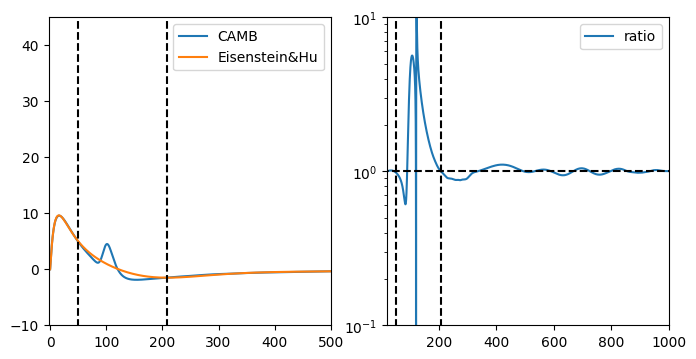

In [21]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

ax[0].plot(s_ext, s_ext**2*corr_lin(s_ext), label = "CAMB")
ax[0].plot(s_ext, s_ext**2*corr_nw(s_ext), label = "Eisenstein&Hu")
ax[0].vlines(50, -100, 100, color = "black", linestyle = "dashed")
ax[0].vlines(208, -100, 100, color = "black", linestyle = "dashed")
ax[0].legend()
ax[0].set_xlim((-2, 500))
ax[0].set_ylim((-10, 45))

ax[1].semilogy(s_ext, abs(corr_lin(s_ext)/corr_nw(s_ext)) , label = "ratio")
ax[1].hlines(1, 0, 2000, ls = '--', color = "black")
ax[1].vlines(50, -5, 25, color = "black", linestyle = "dashed")
ax[1].vlines(208, -5, 30, color = "black", linestyle = "dashed")
ax[1].legend()
ax[1].set_xlim((20, 1000))
ax[1].set_ylim((0.1, 10))

We will assume that the final smooth correlation function should be the same as the camb one outside the dashed lines region but should be equal to the eisenstein one otherwise.

In [22]:
from scipy.special import expit

In [23]:
smin = 50
smax = 220
transition_width = 70

s_gap = s_ext[(s_ext>=smin)&(s_ext<=smax)]
range1 = s_ext[s_ext<smin]
range2 = s_ext[s_ext>smax]

corr_test = np.hstack((corr_lin(range1), corr_nw(s_gap), corr_lin(range2)))
total_range = np.hstack((range1, s_gap, range2))
corr_smooth_final = interp1d(total_range,corr_test)

# Define transition regions
transition_start = smin - transition_width / 2
transition_end = smax + transition_width / 2

# Create blending function
def blend_function(x, start, end):
    return expit((x - start) / (end - start) * 12 - 6)  # Sigmoid function

# Apply blending function
blend1 = blend_function(s_ext, transition_start, smin)
blend2 = blend_function(s_ext, smax, transition_end)

# Compute the combined function
corr_combined = (1 - blend1) * corr_lin(s_ext) + blend1 * corr_nw(s_ext)
corr_combined = (1 - blend2) * corr_combined + blend2 * corr_lin(s_ext)

# Interpolation
corr_smooth_final = interp1d(s_ext, corr_combined, kind='cubic')

In [24]:
#corr_test = np.hstack((corr_lin(range1), corr_nw(s_gap), corr_lin(range2)))
#total_range = np.hstack((range1, s_gap, range2))
#corr_smooth_final = interp1d(total_range,corr_test)

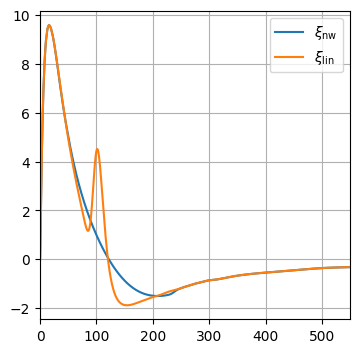

In [25]:
plt.figure(figsize = (4,4))
plt.plot(s_ext, s_ext**2*corr_smooth_final(s_ext), label = r"$\xi_{\rm nw}$")
plt.plot(s_ext, s_ext**2*corr_lin(s_ext), label = r"$\xi_{\rm lin}$")
plt.legend()
plt.xlim((0,550))
plt.grid()

In [26]:
kh_ext, P_smooth_final = xi2P(total_range)(corr_smooth_final(total_range))
ps_nw = interp1d(kh_ext, P_smooth_final)

Text(0, 0.5, '$\\mathcal{O}_{\\rm lin}$')

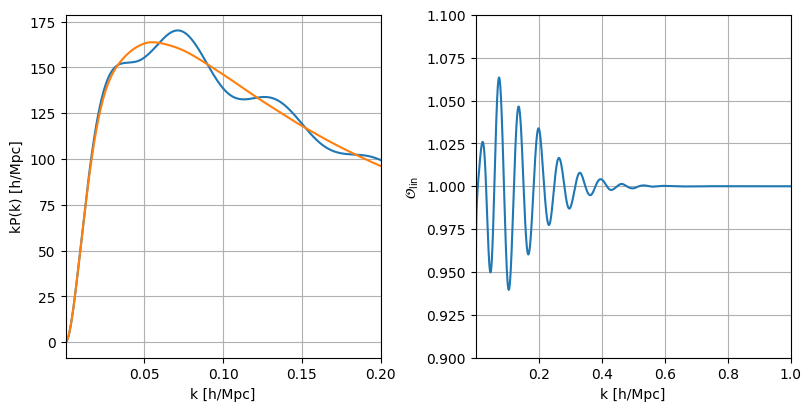

In [27]:
kh_plot = np.logspace(-4,np.log10(1),10000)

fig, ax = plt.subplots(1,2, figsize = (8,4), constrained_layout = True)
ax[0].plot(kh_plot,kh_plot*ps_lin(kh_plot))
ax[0].plot(kh_plot,kh_plot*ps_nw(kh_plot))
ax[0].set_xlim((1e-4,0.2))
ax[0].grid()
ax[0].set_xlabel("k [h/Mpc]")
ax[0].set_ylabel("kP(k) [h/Mpc]")

ax[1].plot(kh_plot,ps_lin(kh_plot)/ps_nw(kh_plot))
ax[1].set_xlim((1e-4,1))
ax[1].set_ylim((0.9,1.1))
ax[1].grid()
ax[1].set_xlabel("k [h/Mpc]")
ax[1].set_ylabel(r'$\mathcal{O}_{\rm lin}$')

In [28]:
O_lin = ps_lin(kh_plot)/ps_nw(kh_plot)

In [29]:
output = np.column_stack((kh_plot,ps_nw(kh_plot),O_lin,ps_lin(kh_plot)))

In [30]:
np.savetxt('DESI_QSO_plin_decomp.txt',output)

# Testing the split